# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

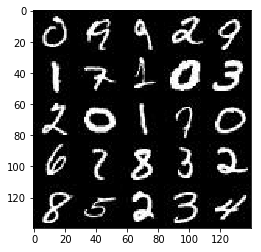

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

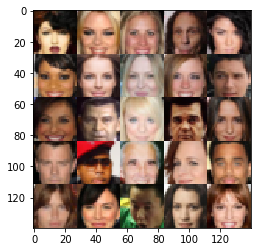

In [3]:
show_n_images = 31

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [31]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))
    fake = tf.placeholder(tf.float32, shape=(None, z_dim))
    lrn_rt   = tf.placeholder(tf.float32)

    return real, fake, lrn_rt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [32]:
# Reviewer's Suggestion:  
#    tf.random_normal_initializer(stddev=0.01)  -->  tf.contrib.layers.xavier_initializer()
#
# Reviewer's Suggestion:
#    Add dropout

def discriminator(images, reuse=False, alpha=0.1, keep_prob=0.9):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                             kernel_initializer = tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same',
                             kernel_initializer = tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=1, padding='same',
                             kernel_initializer = tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(x3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [33]:
# Reviewer's Suggestion:  
#    tf.random_normal_initializer(stddev=0.01)  -->  tf.contrib.layers.xavier_initializer()
#
# Reviewer's Suggestion:
#    Add dropout

def generator(z, out_channel_dim, is_train=True, alpha=0.1, keep_prob=0.9):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :param reuse: Parameter to specify if variables should be reused
    :return: The tensor output of the generator
    """
    
    # TODO: Implement Function  
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob)
        # 7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, filters=128, kernel_size=5, strides=1, padding='same',
                                       kernel_initializer = tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob)
        
        x3 = tf.layers.conv2d_transpose(x2, filters=64, kernel_size=5, strides=2, padding='same',
                                       kernel_initializer = tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob)
        
        x4 = tf.layers.conv2d_transpose(x3, filters=64, kernel_size=5, strides=2, padding='same',
                                       kernel_initializer = tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.nn.dropout(x4, keep_prob)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(
            x3, filters=out_channel_dim, kernel_size=5, strides=2, 
            padding='same', kernel_initializer = tf.contrib.layers.xavier_initializer())
        # 28 x 28 x out_channel_dim 
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [34]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_logits_real, 
            labels = tf.ones_like(d_logits_real)*(1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_logits_fake, 
            labels = tf.zeros_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_logits_fake, 
            labels = tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [35]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [36]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode, alpha=0.1):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False, alpha=alpha),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [37]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
         alpha=0.1, smooth=0.1, print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    :param alpha: leaky relu parameter
    :param smooth: "soft loss" smoothing parameter
    """
    # TODO: Build Model
    #tf.reset_default_graph()
        
    img_w = data_shape[1]
    img_h = data_shape[2]
    img_c = data_shape[3] # or coulud be: len(data_image_mode)
            
    # Get placeholders
    input_real, input_z, lrn_rt = model_inputs(img_w, img_h, img_c, z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, img_c, alpha=alpha, smooth=smooth)
        
    d_opt, g_opt = model_opt(d_loss, g_loss, lrn_rt, beta1)
    

    # TODO: Train Model
    steps=0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                batch_images = 2*batch_images
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lrn_rt: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lrn_rt: learning_rate})
                
                # Reviewer's Comment
                # It's recommended to run g_opt twice as explained here in: 
                #   * http://bamos.github.io/2016/08/09/deep-completion/ 
                #   * https://github.com/carpedm20/DCGAN-tensorflow
                # Run g_opt twice to make sure that d_loss does not go to zero
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lrn_rt: learning_rate})
                
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, img_c, data_image_mode, alpha=alpha)
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [38]:
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
ddd = mnist_dataset.get_batches(1)

### Some suggested reading material
* [How to Make GANs Work](https://github.com/soumith/ganhacks#how-to-train-a-gan-tips-and-tricks-to-make-gans-work)
* [Generating Large Images from Latent Vectors](http://blog.otoro.net/2016/04/01/generating-large-images-from-latent-vectors/)
* [Unsupervised representation learning w/ DCGANs](https://arxiv.org/pdf/1511.06434.pdf)

Epoch 1/2... Discriminator Loss: 1.0536... Generator Loss: 1.1554
Epoch 1/2... Discriminator Loss: 1.0857... Generator Loss: 1.1847
Epoch 1/2... Discriminator Loss: 1.6942... Generator Loss: 0.5346
Epoch 1/2... Discriminator Loss: 0.9228... Generator Loss: 2.0277
Epoch 1/2... Discriminator Loss: 0.8665... Generator Loss: 1.9921
Epoch 1/2... Discriminator Loss: 0.7840... Generator Loss: 1.7263
Epoch 1/2... Discriminator Loss: 0.7151... Generator Loss: 1.8608
Epoch 1/2... Discriminator Loss: 1.2254... Generator Loss: 1.3427
Epoch 1/2... Discriminator Loss: 1.6660... Generator Loss: 0.5896
Epoch 1/2... Discriminator Loss: 1.4617... Generator Loss: 0.8087


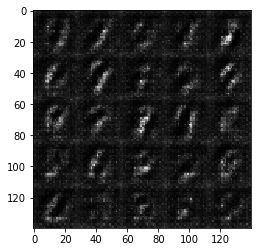

Epoch 1/2... Discriminator Loss: 1.1960... Generator Loss: 1.1292
Epoch 1/2... Discriminator Loss: 1.1933... Generator Loss: 0.8945
Epoch 1/2... Discriminator Loss: 1.2802... Generator Loss: 0.8993
Epoch 1/2... Discriminator Loss: 1.3095... Generator Loss: 0.8155
Epoch 1/2... Discriminator Loss: 1.3579... Generator Loss: 0.7792
Epoch 1/2... Discriminator Loss: 1.6970... Generator Loss: 2.2710
Epoch 1/2... Discriminator Loss: 1.0812... Generator Loss: 1.6626
Epoch 1/2... Discriminator Loss: 1.0225... Generator Loss: 1.3706
Epoch 1/2... Discriminator Loss: 1.1478... Generator Loss: 0.9381
Epoch 1/2... Discriminator Loss: 1.1838... Generator Loss: 0.7440


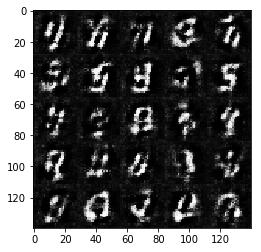

Epoch 1/2... Discriminator Loss: 1.2794... Generator Loss: 2.2011
Epoch 1/2... Discriminator Loss: 1.1698... Generator Loss: 1.4125
Epoch 1/2... Discriminator Loss: 1.2961... Generator Loss: 1.4413
Epoch 1/2... Discriminator Loss: 1.1418... Generator Loss: 0.9864
Epoch 1/2... Discriminator Loss: 1.1332... Generator Loss: 1.7157
Epoch 1/2... Discriminator Loss: 1.1805... Generator Loss: 0.7185
Epoch 1/2... Discriminator Loss: 1.1458... Generator Loss: 1.8042
Epoch 1/2... Discriminator Loss: 1.3434... Generator Loss: 0.5569
Epoch 1/2... Discriminator Loss: 1.1962... Generator Loss: 1.9491
Epoch 1/2... Discriminator Loss: 1.1486... Generator Loss: 0.8280


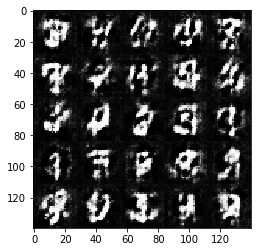

Epoch 1/2... Discriminator Loss: 1.1910... Generator Loss: 1.0858
Epoch 1/2... Discriminator Loss: 1.0884... Generator Loss: 1.7133
Epoch 1/2... Discriminator Loss: 1.1912... Generator Loss: 0.9690
Epoch 1/2... Discriminator Loss: 1.0827... Generator Loss: 0.9172
Epoch 1/2... Discriminator Loss: 0.9686... Generator Loss: 1.7094
Epoch 1/2... Discriminator Loss: 1.1441... Generator Loss: 0.8328
Epoch 1/2... Discriminator Loss: 1.0109... Generator Loss: 1.2242
Epoch 1/2... Discriminator Loss: 0.9702... Generator Loss: 2.0252
Epoch 1/2... Discriminator Loss: 1.2164... Generator Loss: 2.0404
Epoch 1/2... Discriminator Loss: 1.0236... Generator Loss: 1.2653


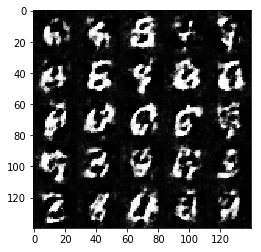

Epoch 1/2... Discriminator Loss: 1.0304... Generator Loss: 1.0360
Epoch 1/2... Discriminator Loss: 0.9442... Generator Loss: 1.2992
Epoch 1/2... Discriminator Loss: 1.0208... Generator Loss: 1.5790
Epoch 1/2... Discriminator Loss: 1.0897... Generator Loss: 1.5028
Epoch 1/2... Discriminator Loss: 1.0887... Generator Loss: 0.9057
Epoch 1/2... Discriminator Loss: 0.9388... Generator Loss: 1.4186
Epoch 1/2... Discriminator Loss: 1.0735... Generator Loss: 1.5579
Epoch 1/2... Discriminator Loss: 1.0229... Generator Loss: 1.5020
Epoch 1/2... Discriminator Loss: 1.0395... Generator Loss: 1.0909
Epoch 1/2... Discriminator Loss: 1.0731... Generator Loss: 0.9939


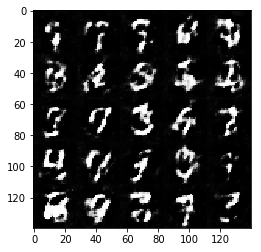

Epoch 1/2... Discriminator Loss: 0.9567... Generator Loss: 1.4520
Epoch 1/2... Discriminator Loss: 1.1779... Generator Loss: 2.1557
Epoch 1/2... Discriminator Loss: 1.1590... Generator Loss: 0.8222
Epoch 1/2... Discriminator Loss: 0.9621... Generator Loss: 1.6355
Epoch 1/2... Discriminator Loss: 0.9747... Generator Loss: 1.2711
Epoch 1/2... Discriminator Loss: 1.0704... Generator Loss: 1.0374
Epoch 1/2... Discriminator Loss: 1.1171... Generator Loss: 1.8380
Epoch 1/2... Discriminator Loss: 1.1750... Generator Loss: 1.6225
Epoch 1/2... Discriminator Loss: 1.1554... Generator Loss: 0.7671
Epoch 1/2... Discriminator Loss: 1.0218... Generator Loss: 1.4699


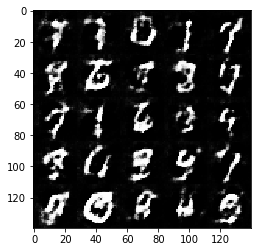

Epoch 1/2... Discriminator Loss: 1.0592... Generator Loss: 1.4533
Epoch 1/2... Discriminator Loss: 1.0787... Generator Loss: 1.1446
Epoch 1/2... Discriminator Loss: 1.1859... Generator Loss: 1.9099
Epoch 1/2... Discriminator Loss: 1.1085... Generator Loss: 1.3429
Epoch 1/2... Discriminator Loss: 1.0913... Generator Loss: 0.9420
Epoch 1/2... Discriminator Loss: 1.1666... Generator Loss: 2.3521
Epoch 1/2... Discriminator Loss: 0.9629... Generator Loss: 1.0405
Epoch 1/2... Discriminator Loss: 1.2367... Generator Loss: 0.8372
Epoch 1/2... Discriminator Loss: 1.1438... Generator Loss: 1.0164
Epoch 1/2... Discriminator Loss: 1.0375... Generator Loss: 1.5790


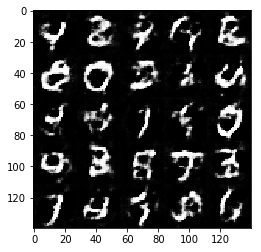

Epoch 1/2... Discriminator Loss: 1.1778... Generator Loss: 1.6566
Epoch 1/2... Discriminator Loss: 1.0863... Generator Loss: 1.1036
Epoch 1/2... Discriminator Loss: 1.2901... Generator Loss: 2.0750
Epoch 1/2... Discriminator Loss: 1.3295... Generator Loss: 1.4760
Epoch 1/2... Discriminator Loss: 1.2242... Generator Loss: 1.1049
Epoch 1/2... Discriminator Loss: 1.2864... Generator Loss: 1.2204
Epoch 1/2... Discriminator Loss: 1.2693... Generator Loss: 0.8389
Epoch 1/2... Discriminator Loss: 1.2136... Generator Loss: 1.0653
Epoch 1/2... Discriminator Loss: 1.0600... Generator Loss: 1.4843
Epoch 1/2... Discriminator Loss: 1.2728... Generator Loss: 1.0459


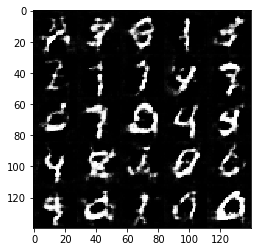

Epoch 1/2... Discriminator Loss: 0.9975... Generator Loss: 1.1596
Epoch 1/2... Discriminator Loss: 1.2533... Generator Loss: 1.6768
Epoch 1/2... Discriminator Loss: 1.3107... Generator Loss: 0.6963
Epoch 1/2... Discriminator Loss: 1.2092... Generator Loss: 0.8516
Epoch 1/2... Discriminator Loss: 1.1741... Generator Loss: 1.1005
Epoch 1/2... Discriminator Loss: 1.1573... Generator Loss: 0.9376
Epoch 1/2... Discriminator Loss: 1.1197... Generator Loss: 1.4050
Epoch 1/2... Discriminator Loss: 1.0765... Generator Loss: 1.5726
Epoch 1/2... Discriminator Loss: 1.1728... Generator Loss: 1.0459
Epoch 1/2... Discriminator Loss: 1.2685... Generator Loss: 0.8150


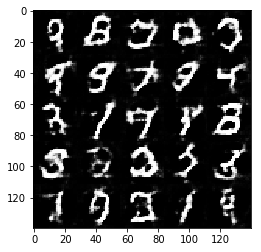

Epoch 1/2... Discriminator Loss: 1.1904... Generator Loss: 0.9419
Epoch 1/2... Discriminator Loss: 1.0581... Generator Loss: 1.1300
Epoch 1/2... Discriminator Loss: 1.1046... Generator Loss: 1.2752
Epoch 2/2... Discriminator Loss: 1.1230... Generator Loss: 0.9055
Epoch 2/2... Discriminator Loss: 1.2597... Generator Loss: 1.6974
Epoch 2/2... Discriminator Loss: 1.1584... Generator Loss: 1.4537
Epoch 2/2... Discriminator Loss: 1.2886... Generator Loss: 0.8671
Epoch 2/2... Discriminator Loss: 1.1421... Generator Loss: 1.2517
Epoch 2/2... Discriminator Loss: 1.1225... Generator Loss: 1.0045
Epoch 2/2... Discriminator Loss: 1.0681... Generator Loss: 1.1397


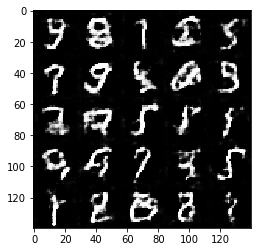

Epoch 2/2... Discriminator Loss: 1.1217... Generator Loss: 0.9850
Epoch 2/2... Discriminator Loss: 1.0493... Generator Loss: 0.9759
Epoch 2/2... Discriminator Loss: 1.2519... Generator Loss: 1.5085
Epoch 2/2... Discriminator Loss: 1.1546... Generator Loss: 1.3333
Epoch 2/2... Discriminator Loss: 1.1860... Generator Loss: 0.8184
Epoch 2/2... Discriminator Loss: 1.1017... Generator Loss: 1.2394
Epoch 2/2... Discriminator Loss: 1.0775... Generator Loss: 1.3753
Epoch 2/2... Discriminator Loss: 1.1066... Generator Loss: 0.9485
Epoch 2/2... Discriminator Loss: 1.1493... Generator Loss: 0.8747
Epoch 2/2... Discriminator Loss: 1.1807... Generator Loss: 0.9427


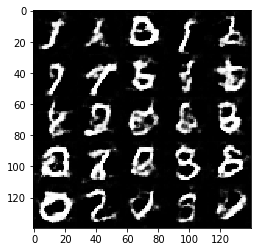

Epoch 2/2... Discriminator Loss: 1.2239... Generator Loss: 1.2484
Epoch 2/2... Discriminator Loss: 1.2255... Generator Loss: 1.1846
Epoch 2/2... Discriminator Loss: 1.1106... Generator Loss: 1.0291
Epoch 2/2... Discriminator Loss: 1.1288... Generator Loss: 0.7076
Epoch 2/2... Discriminator Loss: 1.2235... Generator Loss: 0.9455
Epoch 2/2... Discriminator Loss: 1.1657... Generator Loss: 1.0325
Epoch 2/2... Discriminator Loss: 1.1768... Generator Loss: 1.8966
Epoch 2/2... Discriminator Loss: 1.1487... Generator Loss: 1.0771
Epoch 2/2... Discriminator Loss: 1.0751... Generator Loss: 1.6370
Epoch 2/2... Discriminator Loss: 1.2391... Generator Loss: 0.7784


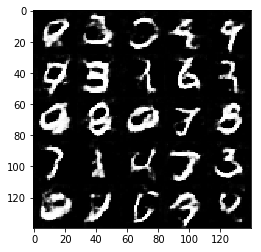

Epoch 2/2... Discriminator Loss: 1.1560... Generator Loss: 0.8539
Epoch 2/2... Discriminator Loss: 1.1658... Generator Loss: 1.3035
Epoch 2/2... Discriminator Loss: 1.1817... Generator Loss: 0.7457
Epoch 2/2... Discriminator Loss: 1.1254... Generator Loss: 1.1035
Epoch 2/2... Discriminator Loss: 1.1828... Generator Loss: 1.1394
Epoch 2/2... Discriminator Loss: 1.1223... Generator Loss: 1.1137
Epoch 2/2... Discriminator Loss: 1.1723... Generator Loss: 1.2385
Epoch 2/2... Discriminator Loss: 1.1501... Generator Loss: 1.2479
Epoch 2/2... Discriminator Loss: 1.0061... Generator Loss: 1.3459
Epoch 2/2... Discriminator Loss: 1.1442... Generator Loss: 1.2210


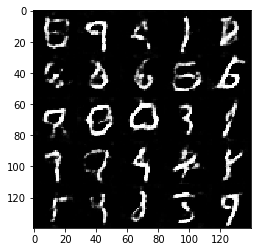

Epoch 2/2... Discriminator Loss: 1.1293... Generator Loss: 1.5796
Epoch 2/2... Discriminator Loss: 1.0769... Generator Loss: 0.9582
Epoch 2/2... Discriminator Loss: 1.2790... Generator Loss: 0.8988
Epoch 2/2... Discriminator Loss: 1.1876... Generator Loss: 0.8252
Epoch 2/2... Discriminator Loss: 1.0365... Generator Loss: 1.1985
Epoch 2/2... Discriminator Loss: 1.0708... Generator Loss: 1.6821
Epoch 2/2... Discriminator Loss: 1.0580... Generator Loss: 1.2698
Epoch 2/2... Discriminator Loss: 1.1704... Generator Loss: 0.8561
Epoch 2/2... Discriminator Loss: 1.1376... Generator Loss: 1.0138
Epoch 2/2... Discriminator Loss: 1.1426... Generator Loss: 1.1858


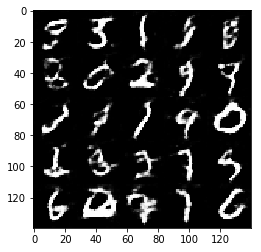

Epoch 2/2... Discriminator Loss: 1.2516... Generator Loss: 0.7350
Epoch 2/2... Discriminator Loss: 1.3753... Generator Loss: 1.9362
Epoch 2/2... Discriminator Loss: 1.0239... Generator Loss: 1.1187
Epoch 2/2... Discriminator Loss: 1.1443... Generator Loss: 1.1471
Epoch 2/2... Discriminator Loss: 1.0530... Generator Loss: 1.1358
Epoch 2/2... Discriminator Loss: 1.1573... Generator Loss: 0.9204
Epoch 2/2... Discriminator Loss: 1.1806... Generator Loss: 1.2619
Epoch 2/2... Discriminator Loss: 1.0517... Generator Loss: 1.3587
Epoch 2/2... Discriminator Loss: 1.0925... Generator Loss: 1.3266
Epoch 2/2... Discriminator Loss: 1.0801... Generator Loss: 1.1696


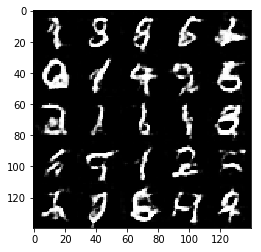

Epoch 2/2... Discriminator Loss: 1.1093... Generator Loss: 0.8917
Epoch 2/2... Discriminator Loss: 1.1173... Generator Loss: 1.3271
Epoch 2/2... Discriminator Loss: 1.1466... Generator Loss: 1.2954
Epoch 2/2... Discriminator Loss: 1.0866... Generator Loss: 1.2923
Epoch 2/2... Discriminator Loss: 1.1376... Generator Loss: 0.7587
Epoch 2/2... Discriminator Loss: 1.1328... Generator Loss: 0.7623
Epoch 2/2... Discriminator Loss: 1.1293... Generator Loss: 0.7918
Epoch 2/2... Discriminator Loss: 1.0545... Generator Loss: 1.0599
Epoch 2/2... Discriminator Loss: 1.0062... Generator Loss: 1.0771
Epoch 2/2... Discriminator Loss: 1.0722... Generator Loss: 1.2461


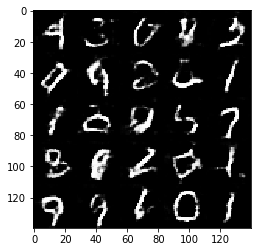

Epoch 2/2... Discriminator Loss: 0.9694... Generator Loss: 1.3150
Epoch 2/2... Discriminator Loss: 1.0287... Generator Loss: 1.0139
Epoch 2/2... Discriminator Loss: 1.1616... Generator Loss: 2.0428
Epoch 2/2... Discriminator Loss: 1.0220... Generator Loss: 1.2834
Epoch 2/2... Discriminator Loss: 1.0575... Generator Loss: 0.9499
Epoch 2/2... Discriminator Loss: 1.0167... Generator Loss: 1.0517
Epoch 2/2... Discriminator Loss: 0.9625... Generator Loss: 1.3851
Epoch 2/2... Discriminator Loss: 0.9297... Generator Loss: 1.7042
Epoch 2/2... Discriminator Loss: 0.9445... Generator Loss: 1.5473
Epoch 2/2... Discriminator Loss: 0.9498... Generator Loss: 1.4213


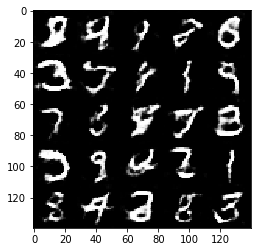

Epoch 2/2... Discriminator Loss: 1.1216... Generator Loss: 1.0580
Epoch 2/2... Discriminator Loss: 0.9621... Generator Loss: 1.2507
Epoch 2/2... Discriminator Loss: 0.9504... Generator Loss: 1.3036
Epoch 2/2... Discriminator Loss: 1.1436... Generator Loss: 1.4694
Epoch 2/2... Discriminator Loss: 0.9879... Generator Loss: 1.6088
Epoch 2/2... Discriminator Loss: 1.0792... Generator Loss: 0.7977
Epoch 2/2... Discriminator Loss: 0.9673... Generator Loss: 1.5996
Epoch 2/2... Discriminator Loss: 1.0211... Generator Loss: 1.4844
Epoch 2/2... Discriminator Loss: 1.1572... Generator Loss: 1.9364
Epoch 2/2... Discriminator Loss: 1.0884... Generator Loss: 1.0433


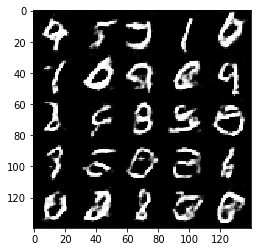

Epoch 2/2... Discriminator Loss: 0.9939... Generator Loss: 0.9561
Epoch 2/2... Discriminator Loss: 1.1386... Generator Loss: 0.8447
Epoch 2/2... Discriminator Loss: 0.9754... Generator Loss: 1.0737
Epoch 2/2... Discriminator Loss: 1.2763... Generator Loss: 0.7770
Epoch 2/2... Discriminator Loss: 1.1648... Generator Loss: 1.4031
Epoch 2/2... Discriminator Loss: 0.9004... Generator Loss: 1.2073
Epoch 2/2... Discriminator Loss: 0.9912... Generator Loss: 1.3054


In [39]:
batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = 0.5
alpha = 0.25
smooth = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
            mnist_dataset.shape, mnist_dataset.image_mode, alpha=alpha, smooth=smooth)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8837... Generator Loss: 1.4911
Epoch 1/1... Discriminator Loss: 0.7258... Generator Loss: 1.8472
Epoch 1/1... Discriminator Loss: 0.5821... Generator Loss: 1.9750
Epoch 1/1... Discriminator Loss: 0.5892... Generator Loss: 2.4204
Epoch 1/1... Discriminator Loss: 0.6281... Generator Loss: 3.6503
Epoch 1/1... Discriminator Loss: 0.5535... Generator Loss: 2.9051
Epoch 1/1... Discriminator Loss: 0.8419... Generator Loss: 1.4153
Epoch 1/1... Discriminator Loss: 0.6764... Generator Loss: 2.6082
Epoch 1/1... Discriminator Loss: 0.5985... Generator Loss: 2.4244
Epoch 1/1... Discriminator Loss: 0.7495... Generator Loss: 1.8541


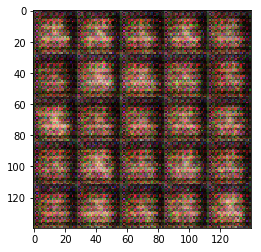

Epoch 1/1... Discriminator Loss: 0.5935... Generator Loss: 3.2950
Epoch 1/1... Discriminator Loss: 0.6103... Generator Loss: 2.8067
Epoch 1/1... Discriminator Loss: 0.4837... Generator Loss: 3.0214
Epoch 1/1... Discriminator Loss: 0.6275... Generator Loss: 2.3301
Epoch 1/1... Discriminator Loss: 0.6920... Generator Loss: 1.7989
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 0.9212... Generator Loss: 1.5977
Epoch 1/1... Discriminator Loss: 0.7382... Generator Loss: 2.6986
Epoch 1/1... Discriminator Loss: 0.7062... Generator Loss: 2.7340
Epoch 1/1... Discriminator Loss: 0.7387... Generator Loss: 1.6810


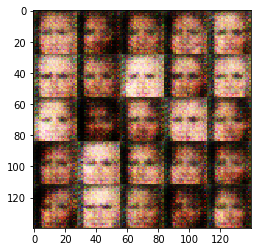

Epoch 1/1... Discriminator Loss: 0.7321... Generator Loss: 3.2373
Epoch 1/1... Discriminator Loss: 0.8232... Generator Loss: 3.2943
Epoch 1/1... Discriminator Loss: 0.9177... Generator Loss: 1.7426
Epoch 1/1... Discriminator Loss: 0.7108... Generator Loss: 2.1489
Epoch 1/1... Discriminator Loss: 0.7281... Generator Loss: 2.3925
Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 3.8907
Epoch 1/1... Discriminator Loss: 0.7447... Generator Loss: 1.9186
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 0.8793... Generator Loss: 1.2609
Epoch 1/1... Discriminator Loss: 0.7752... Generator Loss: 2.5319


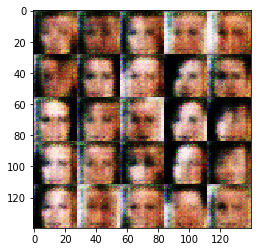

Epoch 1/1... Discriminator Loss: 0.7512... Generator Loss: 2.3596
Epoch 1/1... Discriminator Loss: 0.7658... Generator Loss: 1.6707
Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 0.9957
Epoch 1/1... Discriminator Loss: 0.7393... Generator Loss: 2.1821
Epoch 1/1... Discriminator Loss: 0.7536... Generator Loss: 1.9215
Epoch 1/1... Discriminator Loss: 0.8646... Generator Loss: 1.3655
Epoch 1/1... Discriminator Loss: 0.9225... Generator Loss: 1.2904
Epoch 1/1... Discriminator Loss: 0.7257... Generator Loss: 1.6260
Epoch 1/1... Discriminator Loss: 0.6981... Generator Loss: 2.4241
Epoch 1/1... Discriminator Loss: 0.9489... Generator Loss: 1.2404


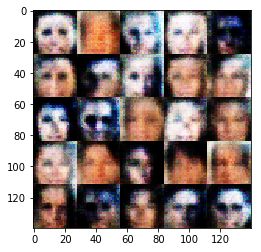

Epoch 1/1... Discriminator Loss: 0.8115... Generator Loss: 2.0873
Epoch 1/1... Discriminator Loss: 0.7830... Generator Loss: 2.1187
Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 0.8683
Epoch 1/1... Discriminator Loss: 0.9353... Generator Loss: 1.8176
Epoch 1/1... Discriminator Loss: 0.9586... Generator Loss: 1.9289
Epoch 1/1... Discriminator Loss: 0.8675... Generator Loss: 1.6662
Epoch 1/1... Discriminator Loss: 0.8925... Generator Loss: 1.3118
Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 1.8662
Epoch 1/1... Discriminator Loss: 0.7754... Generator Loss: 2.0974
Epoch 1/1... Discriminator Loss: 0.9524... Generator Loss: 1.2253


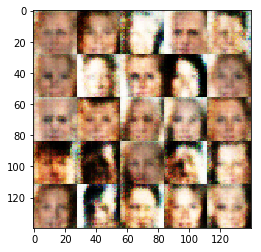

Epoch 1/1... Discriminator Loss: 0.8905... Generator Loss: 1.4628
Epoch 1/1... Discriminator Loss: 0.9989... Generator Loss: 1.8026
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.8975
Epoch 1/1... Discriminator Loss: 1.0993... Generator Loss: 1.4195
Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 2.4552
Epoch 1/1... Discriminator Loss: 1.1286... Generator Loss: 0.9068
Epoch 1/1... Discriminator Loss: 0.9476... Generator Loss: 1.6101
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 1.2834
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 1.9873
Epoch 1/1... Discriminator Loss: 1.1248... Generator Loss: 1.3430


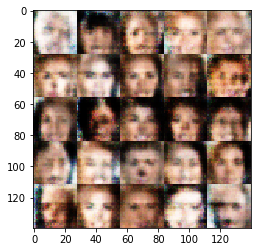

Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 1.5097
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 1.6174
Epoch 1/1... Discriminator Loss: 1.5213... Generator Loss: 1.4944
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 1.8891
Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 0.9735
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 1.0783... Generator Loss: 1.5131
Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 1.2367
Epoch 1/1... Discriminator Loss: 0.9737... Generator Loss: 1.5134
Epoch 1/1... Discriminator Loss: 1.1238... Generator Loss: 1.6479


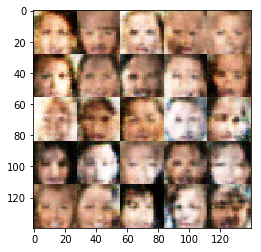

Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 1.3773
Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 1.6437
Epoch 1/1... Discriminator Loss: 1.1683... Generator Loss: 1.0511
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 1.1682
Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 1.0832
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 1.0451
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 1.2230
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 0.9617
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 1.1140
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.9752


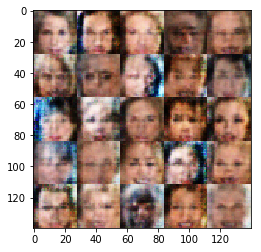

Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 1.2603
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.9720
Epoch 1/1... Discriminator Loss: 1.0580... Generator Loss: 1.4004
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 1.0518
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 1.2584
Epoch 1/1... Discriminator Loss: 1.1907... Generator Loss: 1.1574


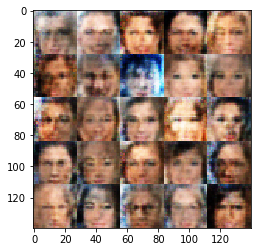

Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 1.2241
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 1.1270
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 1.2479
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.9556
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 1.1307
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 1.1005
Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 1.3328
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 1.3378


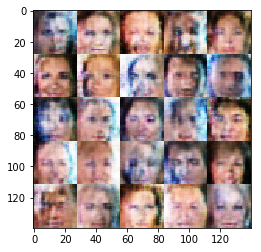

Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 1.0352
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.9324
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 1.1891
Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 1.4498
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 1.0856
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.9919
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 1.0639
Epoch 1/1... Discriminator Loss: 1.5683... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 1.2581


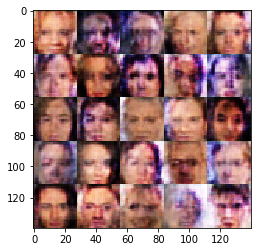

Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 1.0680
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 0.9736
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 1.2491
Epoch 1/1... Discriminator Loss: 1.1217... Generator Loss: 1.3835
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.9135
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 1.4473
Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 1.4265
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.9282
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 0.8555


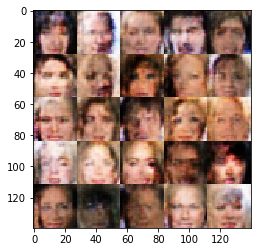

Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.9576
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.9547
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.8942
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 1.0195
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 1.1810
Epoch 1/1... Discriminator Loss: 1.8212... Generator Loss: 0.4675
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.8711


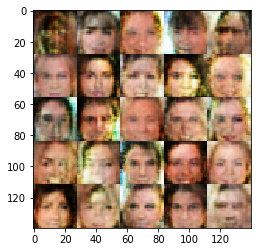

Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 1.0768
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.9874
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 1.5002
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 1.2251
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.9741
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 1.2072
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.9075
Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 1.1832


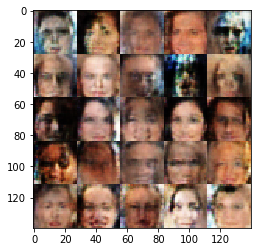

Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 1.1631
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 1.1984
Epoch 1/1... Discriminator Loss: 1.5576... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 1.0764
Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 1.2681
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.6795


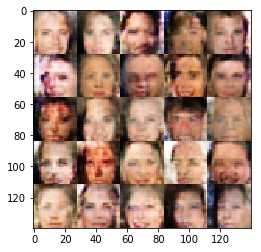

Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.5963
Epoch 1/1... Discriminator Loss: 1.1762... Generator Loss: 0.9487
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 1.4390
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 1.0331
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 1.0969
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 1.0882
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.8855
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.8990


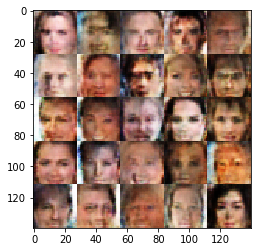

Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 0.9704
Epoch 1/1... Discriminator Loss: 1.1116... Generator Loss: 1.1062
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 1.1355
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 1.0914
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.8951
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 1.1857
Epoch 1/1... Discriminator Loss: 1.0929... Generator Loss: 1.1012
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 1.0180
Epoch 1/1... Discriminator Loss: 1.1792... Generator Loss: 1.1602
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.8641


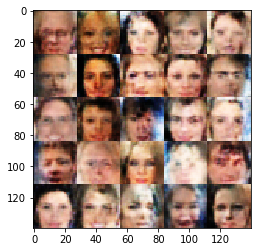

Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.1175... Generator Loss: 0.9292
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 1.0394
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 1.0239
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 1.0707
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.9313
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 1.0034
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.8605


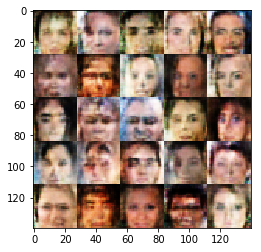

Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.2151... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.5430... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 0.8993
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 1.0515
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.9763
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.7911


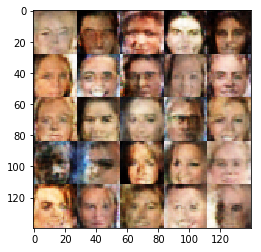

Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 0.9669
Epoch 1/1... Discriminator Loss: 1.0886... Generator Loss: 1.1195
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.5276... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 1.1444... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 1.0813
Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 0.9664
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.7015


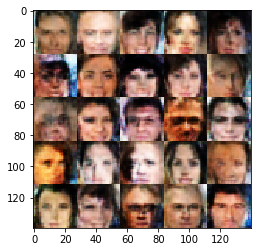

Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 1.1856
Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 1.0738
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.9095
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 0.8905
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.8915
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.6999


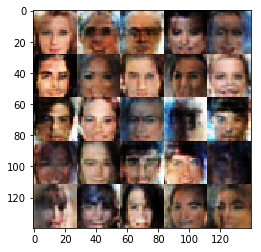

Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.8399
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 0.8971
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 1.0223
Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 1.2592


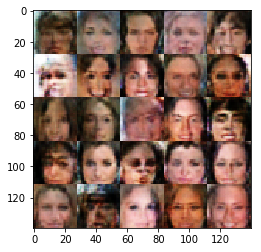

Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.9499
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 1.0525
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.9695
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.5939
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 1.0290
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 1.0406
Epoch 1/1... Discriminator Loss: 1.5543... Generator Loss: 0.8972


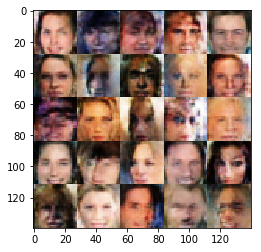

Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 0.9107
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.9824
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.8683
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.9626
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.8369
Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 1.0829
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 1.0266


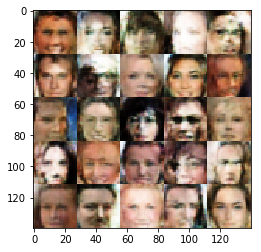

Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.0256... Generator Loss: 1.4164
Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 0.8975
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.8848
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.9789
Epoch 1/1... Discriminator Loss: 1.5375... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.9816


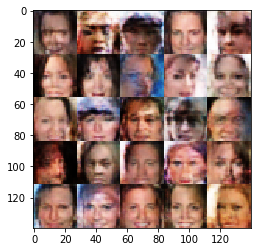

Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 0.9829
Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 1.1431
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.8134
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 1.1951... Generator Loss: 1.2009
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.9664
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.5587... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.9826


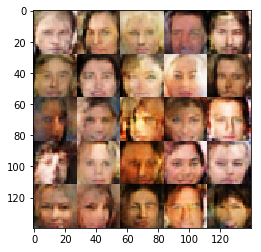

Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.9832
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.9692
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 1.1703
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 0.9683
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 1.0356
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.8992
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.6872


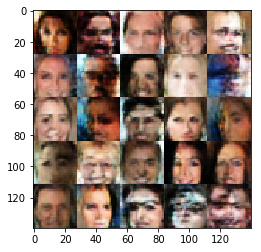

Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.9577
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 1.0483
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 1.0534
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 1.0557
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 0.9103
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 1.2140


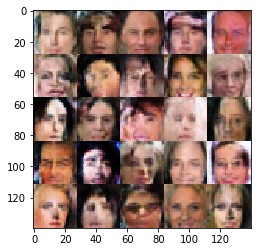

Epoch 1/1... Discriminator Loss: 1.2338... Generator Loss: 0.9474
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 0.9995
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 1.0068
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 0.8904
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 1.0465
Epoch 1/1... Discriminator Loss: 0.9580... Generator Loss: 1.4363
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 0.9795
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.6955


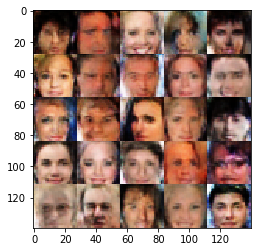

Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.8565
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.9691
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 1.0612
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.8590
Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 0.8451
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 1.0162
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.6479


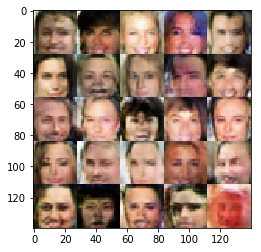

Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 0.9896... Generator Loss: 1.2535
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 1.1054
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.9131
Epoch 1/1... Discriminator Loss: 1.5698... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 1.0303


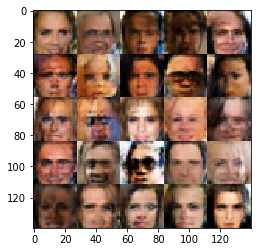

Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 1.1236
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 1.0650
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.8975
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.4933... Generator Loss: 0.7687


In [40]:
batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = 0.5
alpha=0.1
smooth=0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.